In [177]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, cross_val_score, LeaveOneOut

from sklearn.metrics import mean_squared_error

from sklearn.utils import resample

In [4]:
df = pd.read_csv('Auto.csv')
df.shape

(397, 9)

In [5]:
df.head(4)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


In [13]:
# Convert object datatype of horsepower to float datatype 
df['horsepower'] =  pd.to_numeric(df['horsepower'],errors='coerce')

In [14]:
# To see if we have any nan value
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      5
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [15]:
df.dropna(inplace=True)
print(df.shape)
df.isna().sum()

(392, 9)


mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [165]:
x = df['horsepower']
y = df['mpg']

In [166]:
def model_MSE(x, y, order): 
    
    # Split 50% of data into training and 50% into test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 42, shuffle = False)
    
    df_train = pd.DataFrame({'mpg': y_train, 'horsepower': x_train})
    
    formula = 'mpg ~ 1 +' + '+'.join(['I(horsepower**{})'.format(i) for i in np.arange(1, order + 1)])
    
    dic = {1: 'st', 2: 'nd', 3: 'rd'}
    if order < 4:
        suffix = dic[order]
    else: 
        suffix = 'th'
   
    # Create the polynomial model   
    model = smf.ols(formula = formula, data = df_train)
    
    # Fit the model
    result = model.fit()
    
    # Predict mpg on test dataset
    y_test_prediction = result.predict(x_test)
    
    # Mean squarred Error
    MSE = np.mean(y_test - y_test_prediction)**2
    
    # Print Mean Squared Error
    print('MSE of {}{} order polynomial fit function: {}'.format(order, suffix, MSE))
    
    return MSE
  

In [167]:
# MSE of evaluation dataset for a linear model
model_MSE(x, y, 1)  

# MSE of evaluation dataset for a quadratic model
model_MSE(x, y, 2) 

# MSE of evaluation dataset for a cubic model
model_MSE(x, y, 3) 

MSE of 1st order polynomial fit function: 24.521263367513804
MSE of 2nd order polynomial fit function: 22.918389468935647
MSE of 3rd order polynomial fit function: 22.913525056358036


22.913525056358036

MSE of 1st order polynomial fit function: 24.521263367513804
MSE of 2nd order polynomial fit function: 22.918389468935647
MSE of 3rd order polynomial fit function: 22.913525056358036
MSE of 4th order polynomial fit function: 22.82292912275339
MSE of 5th order polynomial fit function: 21.895950359774318
MSE of 6th order polynomial fit function: 22.201487655685643
MSE of 7th order polynomial fit function: 21.603512812872935
MSE of 8th order polynomial fit function: 22.98541068977495
MSE of 9th order polynomial fit function: 31.63552887834209


<IPython.core.display.Javascript object>


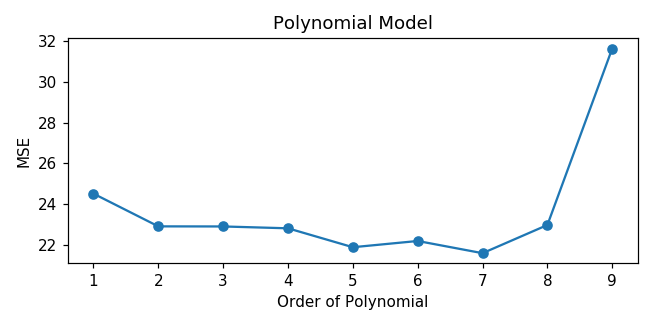

In [168]:
%matplotlib notebook

MSE = []
order_range = range(1, 10)
for order in order_range:
    MSE.append(model_MSE(x, y, order))
    
plt.figure(figsize=(6, 3))
plt.plot(order_range, MSE, marker = 'o')
plt.xlabel('Order of Polynomial')
plt.ylabel('MSE')
plt.title('Polynomial Model')
plt.tight_layout()
plt.savefig('Polynomial_model.png')
    

### Leave-One-Out Cross-Validation

In [170]:
x = df['horsepower'].values
y = df['mpg'].values
x = x[:,np.newaxis]



MSE_list = []
order_range = range(1, 10)
for order in order_range:
    
    # create loocv procedure
    cv = LeaveOneOut()
    
    # Create a linear model
    model = LinearRegression()
    
    # Polynomial features
    poly_reg = PolynomialFeatures(degree=order)
    
    # fit and transform x
    x_poly = poly_reg.fit_transform(x)

    cv.get_n_splits(x_poly)

    y_true, y_pred = [], []
    for train_ix, test_ix in cv.split(x_poly):
        x_train, x_test = x_poly[train_ix, :], x_poly[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        model.fit(x_train, y_train)
        # evaluate model
        y_prediction = model.predict(x_test)

        y_true.append(y_test[0])
        y_pred.append(y_prediction[0])

    SE = [(i - j)**2 for i, j in zip(y_true, y_pred)]
    MSE_LOOCV = np.mean(SE)
    MSE_list.append(MSE_LOOCV)
MSE_list

[24.231513517929226,
 19.248213124489748,
 19.334984064102827,
 19.424430309129928,
 19.033207332300268,
 19.00937528420976,
 19.125997452931603,
 19.224238673880407,
 19.133171458462897]

<IPython.core.display.Javascript object>


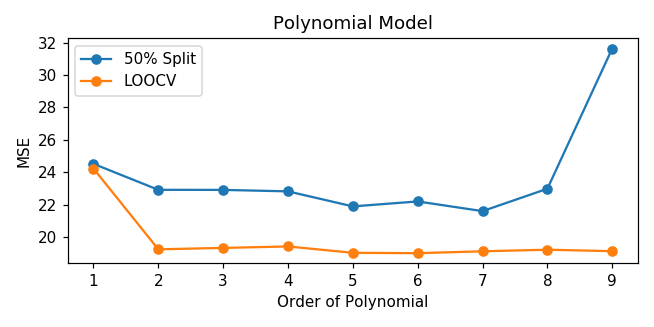

In [171]:
%matplotlib notebook
plt.figure(figsize=(6, 3))
plt.plot(order_range, MSE, marker = 'o', label = '50% Split')
plt.plot(order_range, MSE_list, marker = 'o', label = 'LOOCV')
plt.xlabel('Order of Polynomial')
plt.ylabel('MSE')
plt.title('Polynomial Model')
plt.legend()
plt.tight_layout()
plt.savefig('Polynomial_model_LOOCV.png')

### k-Fold Cross-Validation

In [172]:
x = df['horsepower'].values
y = df['mpg'].values
x = x[:,np.newaxis]

MSE_CV = []
order_range = range(1, 10)
for order in order_range:
    

    
    # Create a linear model
    model = LinearRegression()
    
    # Polynomial features
    poly_reg = PolynomialFeatures(degree=order)
    
    # fit and transform x
    x_poly = poly_reg.fit_transform(x)

    scores = cross_val_score(model, x_poly, y, cv=10, scoring='neg_mean_squared_error')

    MSE_CV.append(-scores.mean())
MSE_CV

[27.439933652339864,
 21.235840055801578,
 21.336606183492037,
 21.353886998802206,
 20.905617540874637,
 20.783345335487972,
 20.953456126709444,
 21.07716809185521,
 21.036900081004017]

<IPython.core.display.Javascript object>


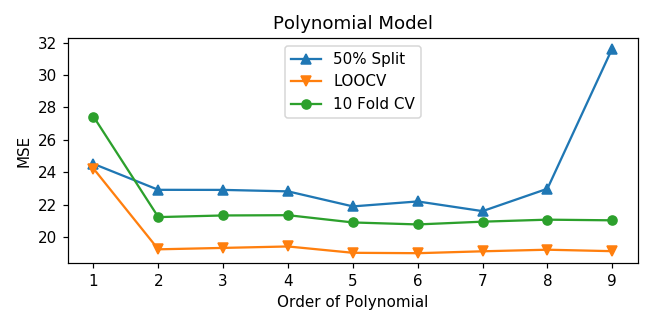

In [174]:
%matplotlib notebook
plt.figure(figsize=(6, 3))
plt.plot(order_range, MSE, marker = '^', label = '50% Split')
plt.plot(order_range, MSE_list, marker = 'v', label = 'LOOCV')
plt.plot(order_range, MSE_CV, marker = 'o', label = '10 Fold CV')
plt.xlabel('Order of Polynomial')
plt.ylabel('MSE')
plt.title('Polynomial Model')
plt.legend()
plt.tight_layout()
plt.savefig('Polynomial_model_CV.png')

### The Bootstrap

#### Estimating the Accuracy of a Statistic of Interest

In [178]:
df_port = pd.read_csv('Portfolio.csv')
df_port.head()

,Unnamed: 0,X,Y
0,1,-0.895251,-0.234924
1,2,-1.562454,-0.885176
2,3,-0.417090,0.271888
3,4,1.044356,-0.734198
4,5,-0.315568,0.841983


In [227]:
# Calculate alpha
np.random.seed(0)
index_array = np.random.choice(len(df_port.index), size = 100, replace = True)
x = df_port['X'][index_array].values
y = df_port['Y'][index_array].values

In [228]:
# We need covariance of of x and y. It is a 2x2 matrix and we need its off diagonal lement
np.cov(x,y)

array([[1.21146823, 0.69437487],
       [0.69437487, 1.35146848]])

In [229]:
np.cov(x, y)[0][1]

0.6943748735487808

In [230]:
# Now alpha is:
alpha = ((np.var(x)-np.cov(x,y)[0][1])/(np.var(x) + np.var(y) - 2 * np.cov(x,y)[0][1]))
alpha

0.43966334199250323

In [233]:
# Lets put everything into a function
def alpha(data, size):
    
    index_array = np.random.choice(len(data.index), size = size, replace = True)
    x = data['X'][index_array].values
    y = data['Y'][index_array].values
    
    return ((np.var(x)-np.cov(x,y)[0][1])/(np.var(x) + np.var(y) - 2 * np.cov(x,y)[0][1]))

np.random.seed(0)
alpha(df_port, 100)

0.43966334199250323